# Performance Attribution #

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_daily_financial_data
from factors_toolkit import FamaFrenchFactors

In [2]:
# Now import the premiums
premiums_df = pd.read_csv(r'..\additional_data\famafrench_premiums.csv')
premiums_df.set_index('Date', inplace=True)
premiums_df.index = pd.to_datetime(premiums_df.index)
premiums_df.columns = ['mkt_premium', 'smb_premium', 'hml_premium', 'risk_free_rate']
premiums_df = premiums_df.div(100)

premiums_df

,mkt_premium,smb_premium,hml_premium,risk_free_rate
Date,,,,
2015-01-02,-0.0012,-0.0059,0.0012,0.00000
2015-01-05,-0.0184,0.0033,-0.0068,0.00000
2015-01-06,-0.0103,-0.0080,-0.0029,0.00000
2015-01-07,0.0119,0.0020,-0.0067,0.00000
2015-01-08,0.0181,-0.0012,-0.0029,0.00000
...,...,...,...,...
2025-03-25,0.0012,-0.0094,0.0005,0.00016
2025-03-26,-0.0122,-0.0048,0.0152,0.00016
2025-03-27,-0.0042,0.0019,0.0030,0.00016


In [3]:
# And we can import the betas
ff_betas = pd.read_csv(r'..\additional_data\famafrench_betas.csv')
ff_betas.rename(columns={'Unnamed: 0': 'stocks'}, inplace=True)
ff_betas.set_index('stocks', inplace=True)

ff_betas

,mkt_beta,smb_beta,hml_beta
stocks,,,
A,0.955686,0.079807,-0.134990
AAPL,1.161827,-0.290220,-0.378872
ABBV,0.616293,-0.301336,0.108055
ABT,0.786172,-0.290043,-0.130577
ADBE,1.253717,-0.235385,-0.681084
...,...,...,...
XYL,1.039345,0.146356,0.256511
YUM,0.760846,-0.183805,0.146926
ZBH,0.830569,0.124457,0.241640


### Fama and French Attribution ###

In [4]:
# Import Stock Data
ticker = 'MSFT'

# Import Data
data_stock = import_daily_financial_data(
    ticker=ticker, 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_stock

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,39.630886,39.973046,39.562452,39.665100,39673900,-0.009238
2015-01-06,39.049202,39.990145,38.955107,39.673647,36447900,-0.014786
2015-01-07,39.545349,39.742092,38.912352,39.331498,29114100,0.012626
2015-01-08,40.708679,40.845544,39.964479,39.990140,29645200,0.028993
2015-01-09,40.366520,40.905425,40.118455,40.725791,23944200,-0.008441
...,...,...,...,...,...,...
2024-12-24,437.647400,437.916385,432.527101,432.985331,7164500,0.009330
2024-12-26,436.432068,439.251246,434.957756,437.398354,8194200,-0.002781
2024-12-27,428.881104,433.553144,424.717120,432.935523,18117700,-0.017453


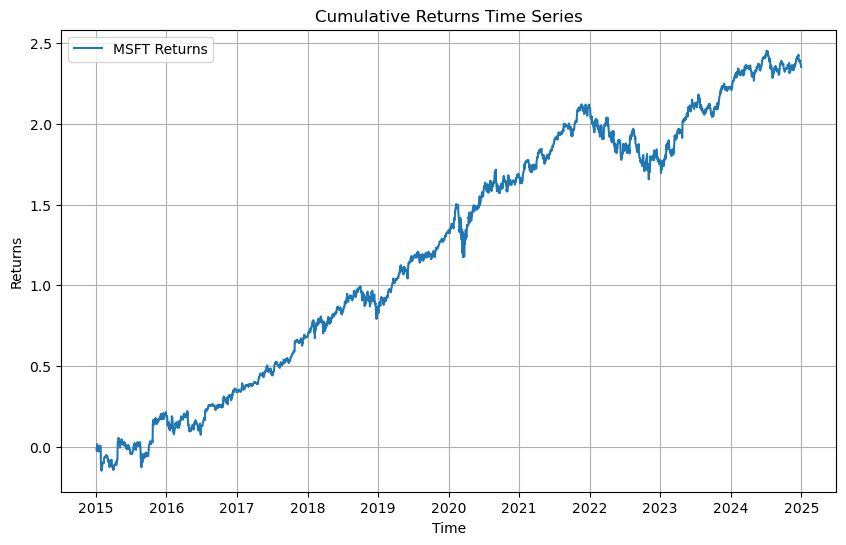

In [5]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data_stock['returns'].cumsum(), label=f'{ticker} Returns', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [6]:
# Now let us calculate the returns according to the beta
mkt_contribution = ff_betas.loc[ticker]['mkt_beta'] * premiums_df['mkt_premium']
mkt_contribution.name = 'mkt_contribution'

# For Size
size_contribution = ff_betas.loc[ticker]['smb_beta'] * premiums_df['smb_premium']
size_contribution.name = 'size_contribution'

# For Value
value_contribution = ff_betas.loc[ticker]['hml_beta'] * premiums_df['hml_premium']
value_contribution.name = 'value_contribution'

In [7]:
# And to calculate the residuals we just have to take the difference
residual_returns = data_stock['returns'] - (mkt_contribution + size_contribution + value_contribution)

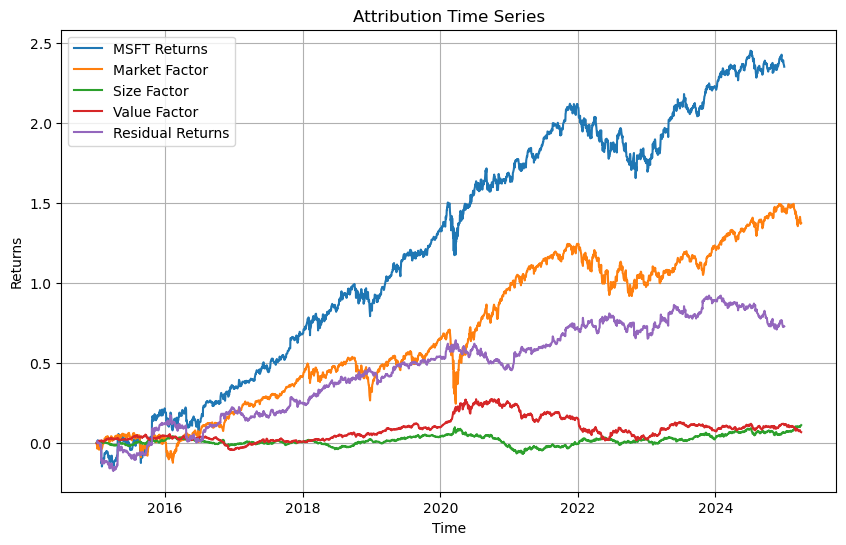

In [8]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data_stock['returns'].cumsum(), label=f'{ticker} Returns', alpha=1)
plt.plot(mkt_contribution.cumsum(), label='Market Factor', alpha=1)
plt.plot(size_contribution.cumsum(), label='Size Factor', alpha=1)
plt.plot(value_contribution.cumsum(), label='Value Factor', alpha=1)
plt.plot(residual_returns.cumsum(), label='Residual Returns', alpha=1)

# Config
plt.title('Attribution Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show() 

### Brinson-Fachley Model ###

In [9]:
# We have to obtain data for our benchmark

# iShares U.S. Technology ETF
data_bench = import_daily_financial_data(
    ticker='IWY', 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_bench

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,44.562851,45.174781,44.481860,45.174781,26600,-0.016821
2015-01-06,44.148903,44.742834,44.049914,44.652843,20700,-0.009332
2015-01-07,44.715828,44.751825,44.445860,44.652836,11700,0.012759
2015-01-08,45.543743,45.597735,45.147787,45.174786,15600,0.018346
2015-01-09,45.201775,45.714715,45.030796,45.714715,26900,-0.007537
...,...,...,...,...,...,...
2024-12-24,243.761948,243.761948,241.094882,241.184780,140800,0.013657
2024-12-26,243.322418,243.991680,241.864031,243.042727,281300,-0.001805
2024-12-27,239.776321,241.874021,237.598723,241.684227,233400,-0.014681


In [35]:
# Now calculate the betas
bench_premium = data_bench['returns'] - premiums_df['risk_free_rate']

# Check if the Function Works
parameters = FamaFrenchFactors(
    bench_premium,
    premiums_df['mkt_premium'],
    premiums_df['smb_premium'],
    premiums_df['hml_premium'],
)

parameters

{'alpha': 3.934727950808859e-05,
 'mkt_beta': 1.0759610461988445,
 'smb_beta': -0.20119068734087817,
 'hml_beta': -0.3282017615265266}

In [29]:
# Create the Parameters Series
bench_parameters = pd.DataFrame([parameters]).T
bench_parameters.columns = ['parameters'] 
bench_parameters = bench_parameters['parameters']

bench_parameters

alpha       0.000039
mkt_beta    1.075961
smb_beta   -0.201191
hml_beta   -0.328202
Name: parameters, dtype: float64

In [51]:
# Import returns 
returns_df = pd.read_csv(r'..\additional_data\stocks_returns.csv')
returns_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
returns_df.set_index('Date', inplace=True)
returns_df.index = pd.to_datetime(returns_df.index)

In [53]:
# Again select a ticker
ticker = 'MSFT'

stock_returns = returns_df[ticker]

In [36]:
# Now calculate the betas
stock_premium = stock_returns - premiums_df['risk_free_rate']

# Check if the Function Works
s_parameters = FamaFrenchFactors(
    stock_premium,
    premiums_df['mkt_premium'],
    premiums_df['smb_premium'],
    premiums_df['hml_premium'],
)

# Create the Parameters Series
stock_parameters = pd.DataFrame([s_parameters]).T
stock_parameters.columns = ['parameters'] 
stock_parameters = stock_parameters['parameters']

stock_parameters

alpha       0.000136
mkt_beta    1.189764
smb_beta   -0.436823
hml_beta   -0.458828
Name: parameters, dtype: float64

### Calculate the Effects ###

In [39]:
# Calculate the Brinson-Fachler Allocation Effect
allocation_effect = (stock_parameters - bench_parameters) * data_bench['returns'].mean()
allocation_effect.name = 'allocation_effect'

allocation_effect.round(6)

alpha       0.000000
mkt_beta    0.000074
smb_beta   -0.000154
hml_beta   -0.000085
Name: allocation_effect, dtype: float64

In [41]:
# Calculate the Brinson-Fachler Selection Effect
selection_effect = bench_parameters * (stock_returns.mean() - data_bench['returns'].mean())
selection_effect.name = 'selection_effect'

selection_effect.round(6)

alpha       0.000000
mkt_beta    0.000302
smb_beta   -0.000056
hml_beta   -0.000092
Name: selection_effect, dtype: float64

In [43]:
# Calculate the Brinson-Fachler Intersection Effect
interaction_effect = (stock_parameters - bench_parameters) * (stock_returns.mean() - data_bench['returns'].mean())
interaction_effect.name = 'interaction_effect'

interaction_effect.round(6)

alpha       0.000000
mkt_beta    0.000032
smb_beta   -0.000066
hml_beta   -0.000037
Name: interaction_effect, dtype: float64

In [45]:
# Calculate the Total Effect
bf_total_attribution = (
        allocation_effect + 
        selection_effect +
        interaction_effect
)

bf_total_attribution.name = 'bf_total_attribution'

bf_total_attribution.round(6)

alpha       0.000000
mkt_beta    0.000408
smb_beta   -0.000277
hml_beta   -0.000214
Name: bf_total_attribution, dtype: float64

In [46]:
# Show
brinson_fachler_df = pd.DataFrame({
    'allocation': allocation_effect,
    'selection': selection_effect,
    'interaction': interaction_effect,
    'total': bf_total_attribution
})

brinson_fachler_df.round(6)

,allocation,selection,interaction,total
alpha,0.000000,0.000000,0.000000,0.000000
mkt_beta,0.000074,0.000302,0.000032,0.000408
smb_beta,-0.000154,-0.000056,-0.000066,-0.000277
hml_beta,-0.000085,-0.000092,-0.000037,-0.000214


In [47]:
brinson_fachler_df.sum().round(6)

allocation    -0.000165
selection      0.000153
interaction   -0.000071
total         -0.000083
dtype: float64

In [49]:
# Divide the DataFrame by the Excess Return
norm_brinson_fachler_df = (brinson_fachler_df/brinson_fachler_df['total'].sum()) * 100

norm_brinson_fachler_df

,allocation,selection,interaction,total
alpha,-0.076771,-0.013350,-0.032894,-0.123015
mkt_beta,-90.117562,-365.066667,-38.612544,-493.796773
smb_beta,186.591206,68.262707,79.948468,334.802381
hml_beta,103.439908,111.356748,44.320750,259.117407


In [50]:
norm_brinson_fachler_df.sum().round(2)

allocation     199.84
selection     -185.46
interaction     85.62
total          100.00
dtype: float64